# Lecture 2

### Dense NN for image classification

In [1]:
from fastai.vision.all import *
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

If the GPU is available use it for the computation otherwise use the CPU.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Fashion MNIST

The Fashion MNIST dataset contains thousands of grayscale images of different types of clothes. There are ten distinct categories encoded into numbers 0 - 10:

0   T-shirt/top

1	Trouser

2	Pullover

3	Dress

4	Coat

5	Sandal

6	Shirt

7	Sneaker

8	Bag

9	Ankle boot

Download the dataset

In [3]:
train_set = datasets.FashionMNIST("./data", download=True, train=True, transform=transforms.Compose([transforms.ToTensor(), torch.flatten]))
test_set = datasets.FashionMNIST("./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor(), torch.flatten]))

100%|██████████| 26421880/26421880 [00:02<00:00, 12891950.37it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 201985.15it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3726066.54it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22445194.38it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



We are going to feed the dataset into our network in batches of size 128 as the dataset is too big to be used all at once.

In [4]:
data_loader = DataLoaders.from_dsets(train_set, test_set, bs=128) # batch size

Let's check the mini batch you'll get from the train data loader:

In [5]:
x, y = next(iter(data_loader.train))
x.size(), y.size()
# x ... image itself, dimension 784 = 28x28
# y ... label of the image, dimension 1

(torch.Size([128, 784]), torch.Size([128]))

In [6]:
len(train_set)

60000

In [7]:
len(test_set)

10000

In [8]:
train_set[0][0].size()

torch.Size([784])

In [9]:
clothes_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                  'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Let's plot some images from our dataset

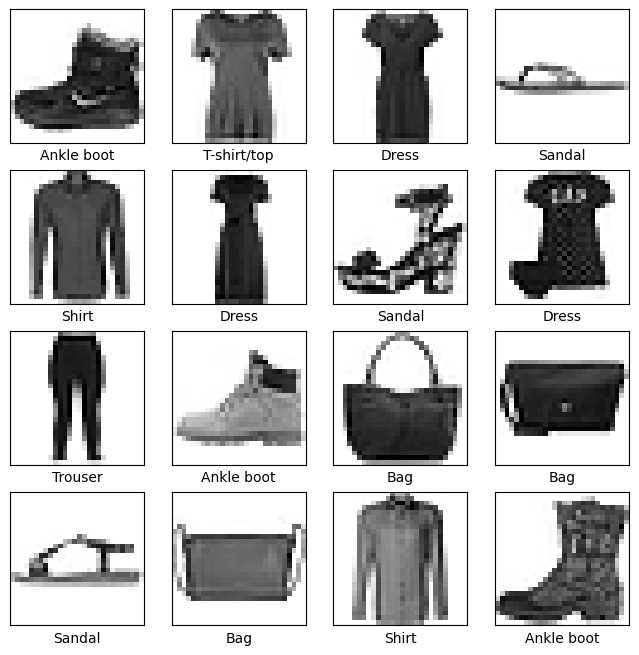

In [10]:
def plot_image(x, title = ""):
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(torch.reshape(x, (28,28)), cmap=plt.cm.binary)
  plt.xlabel(title)

plt.figure(figsize=(8,8))
for i in range(0, 160, 10):
  plt.subplot(4, 4, i // 10 + 1)
  plot_image(train_set[i][0], clothes_labels[train_set[i][1]])

# Dense NN

Let's try to apply dense neural network (we talked about it in the previous lesson) to our images.

All layers are Linear - the classic fully-connected neural network layers.

- The hidden layers will have 128 and 64 units and use the ReLU activation function.
- The output layer will have 10 units, corresponding to the 10 classes, and use softmax function.

The general convention for Pytorch network classes is that you create all your layers in the constructor, and then lay out their relationship in the `forward()` method.

In [11]:
class Net(nn.Module):
    def __init__(self, image_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(image_size, 128) # nn.Linear(n_input_neurons, n_output_neurons)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x): # making connection between layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [12]:
model = Net(image_size= list(train_set[0][0].size())[0])
model.to(device)
model

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [13]:
list(train_set[0][0].size())[0]

784

## Training

In [14]:
# learning rate
lr = 5e-4
# loss function
loss_func = nn.CrossEntropyLoss()

Rather then setting up the model optimization in Pytorch, we are going to use fastai's Learner object. (By default, it uses the Adam optimizer.)

In [15]:
learn = Learner(data_loader, model, loss_func=loss_func, metrics=accuracy)

In [16]:
learn.fit(n_epoch=3, lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.687114,1.687146,0.782400,00:14
1,1.666397,1.662062,0.804200,00:11
2,1.635815,1.637805,0.827400,00:11


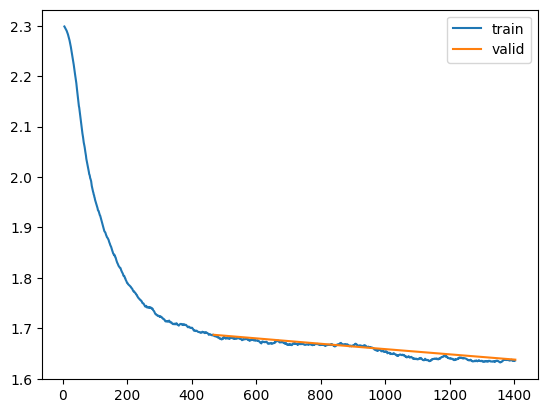

In [17]:
learn.recorder.plot_loss()



---



# CNN

Let's try a different architecture, this time a Convolutional Neural Network

Load data in different format

In [18]:
train_set = datasets.FashionMNIST("./data", download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
test_set = datasets.FashionMNIST("./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

data_loader = DataLoaders.from_dsets(train_set, test_set, bs=128)

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # kernel_size ... number or tuple to get assymetric shape
        # in_channels ... input channels - number of channels of input picture, we have grey picture => one channel
        # out_channels ... output channels - how many patterns are we looking for - number of kernels / patterns used in CNN
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(in_features=24*24*64, out_features=128)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [20]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(in_features=22*22*32, out_features=128)
        self.drop = nn.Dropout(0.1)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [21]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(in_features=22*22*32, out_features=256)
        self.drop = nn.Dropout(0.1)
        self.fc2 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [22]:
model = CNN()
model.to(device)
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=36864, out_features=128, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [23]:
model1 = CNN1()
model1.to(device)
model1

CNN1(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=15488, out_features=128, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [24]:
model2 = CNN2()
model2.to(device)
model2

CNN2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=15488, out_features=256, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

### Training

In [25]:
# learning rate
lr = 5e-4
# loss function
loss_func = nn.CrossEntropyLoss()
# number of epochs
epochs = 5

Rather then setting up the model optimization in Pytorch, we are going to use fastai's Learner object. (By default, it uses the Adam optimizer.)

In [26]:
learn = Learner(data_loader, model, loss_func=loss_func, metrics=accuracy)
learn1 = Learner(data_loader, model1, loss_func=loss_func, metrics=accuracy)
learn2 = Learner(data_loader, model2, loss_func=loss_func, metrics=accuracy)

In [27]:
learn.fit(epochs, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.627000,1.618002,0.846100,00:16
1,1.595727,1.595587,0.867000,00:11
2,1.586376,1.593310,0.867800,00:12
3,1.579965,1.580245,0.881100,00:12
4,1.569660,1.577127,0.884200,00:11


In [28]:
learn1.fit(epochs, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.724352,1.717667,0.742100,00:12
1,1.676351,1.665784,0.795100,00:12
2,1.656429,1.662667,0.797900,00:12
3,1.655574,1.654450,0.805800,00:12
4,1.632527,1.606496,0.854500,00:12


In [29]:
learn2.fit(epochs, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.656169,1.654303,0.806800,00:12
1,1.601104,1.611056,0.851900,00:12
2,1.580462,1.594459,0.867900,00:12
3,1.576570,1.579743,0.882400,00:12
4,1.568861,1.572493,0.888900,00:12


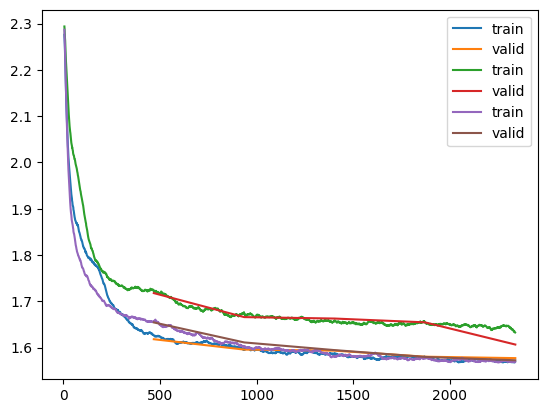

In [30]:
learn.recorder.plot_loss()
learn1.recorder.plot_loss()
learn2.recorder.plot_loss()

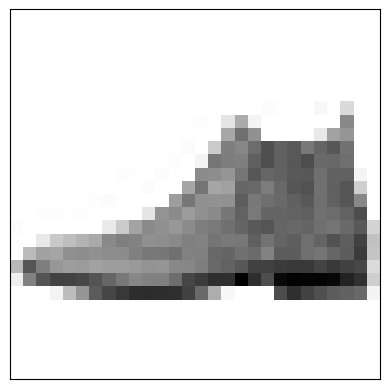

In [31]:
plot_image(test_set[0][0])

In [62]:
print(clothes_labels[torch.argmax(learn.predict(test_set[0])[0])])
print(clothes_labels[torch.argmax(learn1.predict(test_set[0])[0])])
print(clothes_labels[torch.argmax(learn2.predict(test_set[0])[0])])

Ankle boot


Ankle boot


Ankle boot
